In [1]:
import os
import shutil

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *


import h5py
import glob
import zipfile
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

tf.random.set_seed(22)
np.random.seed(2022)

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
# import cv2

## 文件解压，数据显示，以及本文所使用的参考链接
- 多模型特征向量组合方式:[参考1](https://zhuanlan.zhihu.com/p/25978105)
- 特征提取介绍: [参考2](https://dev.mrdbourke.com/tensorflow-deep-learning/04_transfer_learning_in_tensorflow_part_1_feature_extraction/)
- Tensorflow迁移学习介绍: [参考3](https://tensorflow.google.cn/tutorials/images/transfer_learning?hl=en)
- 用于微调的checkpoint: [参考4](https://github.com/tensorflow/models/blob/master/research/slim/README.md#pre-trained-models)
- Tensorflow hub特征向量与模型汇总: [参考5](https://hub.tensorflow.google.cn/s?module-type=image-feature-vector&tf-version=tf2)
- 最终kaggle提交结果: [最佳结果:0.03694](./best_result.png)

In [2]:
# 解压部分 将数据集文件夹拷贝到当前工作目录下面来,如果没有解压，可以使用下述代码自动解压，
# def dataset_extractor(base_dir):
#     train_dir = os.path.join(base_dir, "train.zip")
#     test_dir = os.path.join(base_dir, "test.zip")
#     if not os.path.exists("./dogs-vs-cats-redux-kernels-edition/train"):
#         with zipfile.ZipFile(train_dir,"r") as z:
#             z.extractall(base_dir)
#             z.close()
#     if not os.path.exists("./dogs-vs-cats-redux-kernels-edition/test"):
#         with zipfile.ZipFile(test_dir,"r") as z:
#             z.extractall(base_dir)
#             z.close()
            
# base_dir = "./dogs-vs-cats-redux-kernels-edition"         
# dataset_extractor(base_dir=base_dir)

In [3]:
#数据处理，将原文件夹下混合的猫狗文件拷贝到当前目录下来并且分类
# def create_dataset():
#     train_cat = glob.glob('./dogs-vs-cats-redux-kernels-edition/train/cat*.jpg')
#     train_dog = glob.glob('./dogs-vs-cats-redux-kernels-edition/train/dog*.jpg')
#     test_dog_cat = glob.glob('./dogs-vs-cats-redux-kernels-edition/test/*')

#     if not os.path.exists('train'):
#         os.mkdir('train'
#         os.mkdir('train/cat')
#         os.mkdir('train/dog')
#         for filename in train_cat:
#             shutil.copy(filename, 'train/cat/'+os.path.basename(filename))
#         for filename in train_dog:
#             shutil.copy(filename, 'train/dog/'+os.path.basename(filename))
#     if not os.path.exists('test'):
#         os.mkdir('test')
#         os.mkdir('test/cat_dog')
#         for filename in test_dog_cat:
#             shutil.copy(filename,'test/cat_dog/'+os.path.basename(filename))
            
# create_dataset()

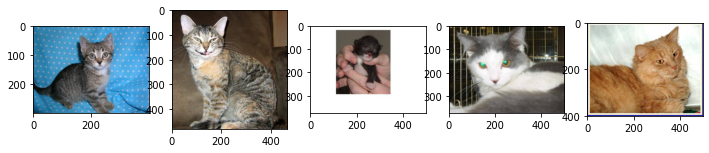

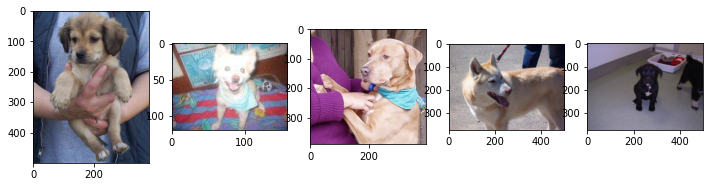

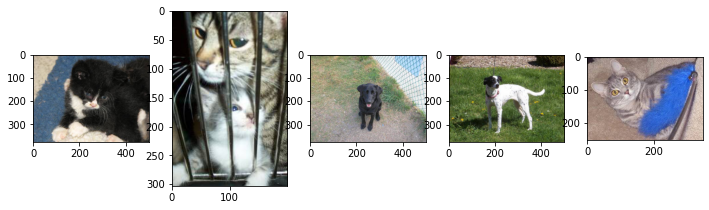

In [2]:
#图像展示 PIL.Image + plt.imshow
def show_image(file_path):
    file_list = glob.glob(file_path)
    fig = plt.figure(figsize=(12,16))
    for i in range(5):
        img = Image.open(file_list[i])
        sub_img = fig.add_subplot(151+i)
        sub_img.imshow(img)

train_cats_list = "./train/cat/*"
train_dogs_list = "./train/dog/*"
test_dogs_list = "./test/cat_dog/*"
#可以看到图像的大小填充程度均不统一，因此需要进行进一步的处理    
# show_image(real_cats)
show_image(train_cats_list)
show_image(train_dogs_list)
show_image(test_dogs_list)

## 特征向量的提取
- CPU：12核 Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz 内存:60GB
- GPU：Tesla P40 * 1 显存:24GB
- 由于原始版本的迁移学习在训练一个epoch时极其缓慢，在服务器Tesla P40-24GB上也需要大概3分钟左右生成一次epoch，这对于调节超参数极其煎熬，所以选择先导出特征向量然后作为新的感知机模型输入，这几乎可能在30s之内完成对于10个epoch的训练
- 本模型测试了：EfficientNetV2B0/ResNet50/ResNet101/ResNet152/Xception/InceptionV3/VGG16/VGG19多种模型在单一和组合条件下的效果
- 包括在没有数据增强的条件下/使用不包括将\[0,255\]放缩到\[0,1\]/使用包括放缩在内的全部常见的数据增强(后证明不应该加入此选项，应使用keras.application选项中给予的自动调节preprocess_input)
- 最优结果出现在使用：1. 没有数据增强的'Xception.h5','InceptionV3.h5' 2. 使用了数据增强的'EfficientNetV2B0_plus.h5' 共三个模型的组合选项

In [3]:
# transfer learning
def use_pretrained_model_parameter(MODEL, image_size, lambda_func=None):
    #定义不同的模型所需要的大小
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    print(width,height)
    
    #默认裁剪的大小为256*256
    train_dataset = tf.keras.utils.image_dataset_from_directory("train",
                                                               image_size=image_size,
                                                               batch_size=16,
                                                               shuffle=False,
                                                                labels='inferred'
                                                               )
    test_dataset = tf.keras.utils.image_dataset_from_directory("test",
                                                               image_size=image_size,
                                                               batch_size=16,
                                                               shuffle=False,
                                                                labels='inferred'
                                                               )
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Resizing(256,256),#应该能够被image_size替代，但是不知道为什么不行。
        tf.keras.layers.CenterCrop(height,width), #借助中心裁剪成输入所需要的大小，替代resize
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.5),
#         tf.keras.layers.RandomBrightness(0.5), #tf-nightly可用
#         tf.keras.layers.RandomWidth(0.2),
#         tf.keras.layers.RandomHeight(0.2),
        
    ])
    
    #定义模型(这里仅仅为训练集定义了数据增强，已经测试版本同时使用了数据增强，下列代码未经测试，如果跑不通，可以合并train_x/test_x=>x)   
    train_x = input_tensor
    test_x = input_tensor
    
    train_x = data_augmentation(train_x)  
    test_x = test_x #rescale和resize已经默认做的，因此训练样本不经过任何处理
    #由于预处理范围不一定一样，因此使用模型默认的preprocess_input去替代数据增强的rescale
    if lambda_func:
        train_x = Lambda(lambda_func)(train_x)
        test_x = Lambda(lambda_func)(test_x)
    train_base_model = MODEL(input_tensor=train_x, weights='imagenet', include_top=False)
    test_base_model = MODEL(input_tensor=test_x, weights='imagenet', include_top=False)
    #print(base_model.input.shape)
#     print(base_model.output.shape)
    model1 = Model(train_base_model.input,
                  GlobalAveragePooling2D()(train_base_model.output))
    model2 = Model(test_base_model.input,
                  GlobalAveragePooling2D()(test_base_model.output))


    train = model1.predict(train_dataset)
    test = model2.predict(test_dataset)
    print(train.shape,test.shape)
    print(train_dataset.classes)
          
    with h5py.File("%s.h5"%MODEL.__name__,'w') as f:
        f.create_dataset("train", data=train)
        f.create_dataset("test", data=test)
        f.create_dataset("label", data=train_dataset.classes)
  

In [165]:
# if not os.path.exists('*.h5'): #可选的下载
#     use_pretrained_model_parameter(EfficientNetV2B0,(224,224),efficientnet_v2.preprocess_input)
#     use_pretrained_model_parameter(ResNet50, (224, 224),resnet50.preprocess_input)
#     use_pretrained_model_parameter(ResNet101, (224, 224),resnet.ResNet101.preprocess_input)
#     use_pretrained_model_parameter(ResNet152, (224, 224),resnet.ResNet152.preprocess_input)
#     use_pretrained_model_parameter(Xception, (299, 299), xception.preprocess_input)
#     use_pretrained_model_parameter(InceptionV3, (299, 299), inception_v3.preprocess_input)
#     use_pretrained_model_parameter(VGG16, (224, 224),vgg16.preprocess_input)
#     use_pretrained_model_parameter(VGG19, (224, 224),vgg19.preprocess_input)

In [3]:
#准备数据
X_train = []
X_test = []

pretrain_model = ['EfficientNetV2B0_plus.h5','InceptionV3.h5','Xception.h5',]#'ResNet50.h5',
for filename in pretrain_model: # 
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)



### 构建模型
- 测试结果表明：
- dropout率设置为0.45/0.5两个值会拥有更好的效果
- 增加更多的全连接层会显著降低kaggle得分
- Adam设置为1e-3时，kaggle得分会更稳定保持0.037XX,经过多次试验，其最好成绩为0.036XX
- 对于model.fit=>epochs设置为9或者10,低于此值或高于此值均降低kaggle得分，validation_split选项应去掉，即在生成提交数据时完全不使用验证集
- 由于kaggle的评估计算是基于logloss的，其对于错误差距的小数点极其敏感，因此应该参考预测结果对预测进行相应裁剪，如本模型中为0.9956xxx,将y_pred.clip裁剪到\[0.003,0.995\]，不加入裁剪会降低到0.038左右 
- checkpoint和model两种预训练均已给出，可以反注释掉相应的地方以使用
- 无论是使用batchnorm还是layernorm都不能增加得分
- 加入正则化基本不会起任何作用kernel_regularizer=keras.regularizers.l2(1e-4)                                   

In [4]:
X_train, y_train = shuffle(X_train, y_train)


#可选:使用已经训练的模型
# if os.path.exists('model-kaggle-dogs-vs-cats'):
#     tf.keras.models.load_model('./model-kaggle-dogs-vs-cats')
# else:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
# x = BatchNormalization()(x)
# x = LayerNormalization()(x)
x = Dropout(0.5)(x) 
# x = Dense(1024,activation='relu',kernel_regularizer=keras.regularizers.l2(1e-3))(x) #加上一层全连接并不能加大准确率
# x = Dropout(0.2)(x)
x = Dense(1,activation='sigmoid')(x) 


#in Model(first_layer,last_layer)    
model = Model(input_tensor, x)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss = tf.keras.losses.BinaryCrossentropy(),
#               metrics=['binary_accuracy'],
              metrics=['accuracy']
             )


Metal device set to: Apple M1


2022-05-09 22:36:59.435139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 22:36:59.435524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
#绘制与可视化模型
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)
#查看每层和参数
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5376)]            0         
                                                                 
 dropout (Dropout)           (None, 5376)              0         
                                                                 
 dense (Dense)               (None, 1)                 5377      
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


In [7]:
#随着训练量的增加，在训练集上和验证集上均开始有着非常好的结果。但是kaggle上的提交得到再减少，应该是明显地过拟合，建议适当屏蔽掉checkpoint
# if os.path.exists('./checkpoint/'):
#     lastest = tf.train.latest_checkpoint('./checkpoint')
#     print('load latest checkpoint!!')
#     model.load_weights(lastest)
# # # all_cp = tf.train.list_variables('./checkpoint')
# # # print(all_cp)
# checkpoint_path = "./checkpoint/cp-{epoch:04d}.ckpt"

batch_size = 256
# ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                   save_weights_only=True,
#                                                   save_best_only=True,
#                                                    verbose=1,
#                                                    save_freq=batch_size
#                                                   )
# import datetime
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

combined_model_history = model.fit(X_train, y_train, 
                                   batch_size=batch_size, 
                                   epochs=10,
#                                    validation_split=0.03,
#                                    callbacks=[ckpt_callback,tensorboard_callback]
                                  )

Epoch 1/10


2022-05-09 22:37:26.155982: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-09 22:37:26.292328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 1s 7ms/step - loss: 0.0892 - accuracy: 0.9729
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0238 - accuracy: 0.9935
Epoch 3/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0190 - accuracy: 0.9946
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0166 - accuracy: 0.9951
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0158 - accuracy: 0.9954
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0138 - accuracy: 0.9958
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0135 - accuracy: 0.9962
Epoch 8/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0124 - accuracy: 0.9964
Epoch 9/10
98/98 [==============================] - 1s 7ms/step - loss: 0.0118 - accuracy: 0.9964
Epoch 10/10
98/98 [==============================] - 1s 6ms/step - loss: 0.0107 - accuracy: 0.9966


In [8]:
#绘制损失曲线
def plot_loss_curves(history):
    acc = history.history['accuracy']
    loss = history.history['loss']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    with plt.xkcd():
        
        plt.figure(figsize=(20,6))
        
        plt.subplot(1,2,1)
        plt.plot(epochs,acc,'b',label='Training accuracy')
        plt.plot(epochs,val_acc,'r',label='Validation accuracy')
        plt.title('accuracy!')
        plt.xlabel('Epochs')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(epochs,loss,'b',label='Training loss')
        plt.plot(epochs,val_loss,'r',label='Validation loss')
        plt.title('Loss!')
        plt.xlabel('Epochs')
        plt.legend()
        
        plt.show()

# plot_loss_curves(combined_model_history)

In [9]:
# model.save('model-kaggle-dogs-vs-cats')

In [15]:
#模型预测
y_pred = model.predict(X_test, verbose=1) #这里的测试集实际上就来自于X_test.append(np.array(h['test']))的测试集
# y_pred[y_pred > 0.9973] = 1
# y_pred[y_pred <  0.0018] = 0
y_pred = y_pred.clip(min=0.003, max=0.995)
# y_pred = y_pred.clip(min=0.0018,max=0.9973)

391/391 [==============================] - 0s 1ms/step


In [16]:
#将预测结果导出到csv

df= pd.read_csv('./sample_submission.csv')

test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_directory("test/",shuffle=False)

for i, fname in enumerate(test_generator.filenames):
    #按照文件名取出索引，如cat_dog/1.jpg=>1,cat_dog/100.jpg=>100
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    #事实上，由于test_generator.filenames所产生的预测是y_pred[1]=>1.jpg,y_pred[2]=>100.jpg，而csv_id按照顺序来
    #所以，只能使用从文件名中提取出来的数，然后使用df.at去定位，但是这种定位按照列数定位，由于行首标签占用一行，因此需要减去
    df.at[index-1, 'label'] =  y_pred[i]

df.to_csv('sub_prediction.csv', index=None)
print("print success!")

Found 12500 images belonging to 1 classes.
print success!
